# Статистика, DS-поток
## Практическое задание 1


**Правила:**

* Дедлайн **26 сентября 23:59**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds20_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 -  10 баллов
* Задача 2 -  10 баллов
* Задача 3 -  5 баллов
* Задача 4 -  15 баллов

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt

%matplotlib inline

---
## Задача 1.

Реализуйте метод Монте-Карло и метод прямоугольников численного интегрирования функции. Реализация должна уметь вычислять интеграл вида:
$$ \int\limits_{l_1}^{h_1} ... \int\limits_{l_d}^{h_d} f(x_1, ... , x_d) dx_1 ... dx_d $$

*Детали реализации*: на вход функции подаются векторы $l = (l_1, ... , l_d)$ и $h = (h_1, ... ,h_d)$, число $n$ -- максимальное допустимое число вызовов функции $f$ (если вы не делаете лишних вызовов, оно равно числу точек-центров отрезков, прямоугольников, параллелипипедов, и т.д. в многомерных случаях). Использование циклов, кроме циклов по числу интегралов $d$, **наказуемо**.

Для быстрой работы метода прямоугольников мы будем использовать функцию <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html">`numpy.meshgrid`</a>. Ниже есть пример ее использования. Как всегда, настоятельно советуем читать документацию.

In [2]:
# Предположим, мы хотим получить координаты всех целых точек (x, y), 
# таких, что x лежит в промежутке [5, 6], а y - в промежутке [-3, -1]

linspace_x = [5, 6]  
linspace_y = [-3, -2, -1]

# возвращает матрицы с координатами сетки,
# задаваемой проекциями точек на оси координат
X, Y = np.meshgrid(linspace_x, linspace_y)

print("X: ", X)  # linspace_x повторилась len(linspace_y) раз по оси 0
print("Y: ", Y)  # linspace_y повторилась len(linspace_x) раз по оси 1

# преобразуем исходный формат к вектору точек
np.stack([X, Y]).reshape(2, -1).T

X:  [[5 6]
 [5 6]
 [5 6]]
Y:  [[-3 -3]
 [-2 -2]
 [-1 -1]]


array([[ 5, -3],
       [ 6, -3],
       [ 5, -2],
       [ 6, -2],
       [ 5, -1],
       [ 6, -1]])

In [3]:
class Integrator:
    
    @staticmethod
    def integrate(f, low, high, n, method="rectangle"):
        """
        Вычисление определенного интеграла.
        
        Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
        n --- максимальное число вызовов функции f.
        method --- метод ("rectangle" или "monte_carlo").
                            
        Возвращает приближенное значение интеграла.
        """
        
        assert len(low) == len(high)
        low, high = map(np.array, [low, high])
        n = int(n)

        return Integrator.methods[method](f, low, high, n)
    
    
    def integrate_monte_carlo(f, low, high, n):
        """Метод монте-карло"""
        
        dim = len(high)
        
        # случайные точки, в которых будем вычислять функцию
        dots = sps.uniform.rvs(loc=low, scale=high-low, size=(n, dim))
        
        diff = high - low # длины отрезков разбиения
        
        # вычисление интеграла
        return f(dots).mean() * np.prod(high - low)
    
    
    def integrate_rectangle(f, low, high, n):
        """Метод прямоугольников"""
        
        dim = len(high)
        
        # количество точек, в которых вычисляем функцию
        n_rounded = int(np.floor(n**(1 / dim)))
        
        diff = (high - low) / (n_rounded - 1) # длины отрезов разбиения
    
        centers_of_ranges = np.zeros((dim, n_rounded - 1))
        
        # для каждой размерности найдите центры отрезков разбиения
        for d in range(dim):
            centers_of_ranges[d] = np.linspace(
                low[d] + diff[d] / 2, high[d] - diff[d] / 2, n_rounded - 1
            )
        
        centers = np.meshgrid(*centers_of_ranges)
        f_vals = f(np.stack(centers).reshape(dim, -1).T)
        return f_vals.sum() * np.prod(diff)
    
    
    methods = {
        "rectangle": integrate_rectangle,
        "monte_carlo": integrate_monte_carlo
    }

Вычислите $\int\limits_0^1 \int\limits_3^4 \left(x^2 + y^2\right) dxdy$ на миллионе запусков функции $f(x, y) = x^2+y^2$ двумя рассмотренными методами. Измерьте время работы методов и сравните результат с истинными значением интеграла. Различается ли время работы методов? Объясните результаты с точки зрения теории.

In [4]:
square_sum = lambda x: np.sum(x**2, axis=1)

In [5]:
low = [0, 3]
high = [1, 4]
n = 1e6

In [10]:
print("By rectangle: I = {0:.7f}".format(
    Integrator.integrate(square_sum, low, high, n))
     )

By rectangle: I = 12.6666665


In [11]:
print("By Monte-Karlo: I = {0:.7f}".format(
    Integrator.integrate(square_sum, low, high, n, method='monte_carlo'))
     )

By Monte-Karlo: I = 12.6667803


**Вывод:** 1) Истинный результат равен $\frac{38}{3} = 12.(6)$, поэтому различие в ответах равно $10^{-7}$  и $10^{-3}$ для метода прямоугольников и метода Монте-Карло соответственно. Т. е. метод прямоугольников точнее в $10^4$ раз.

2) Метод прямоугольников стабильно в 2 раза быстрее: для тякущего запуска имеем $73$ ms против $124$ ms.

3) Теория говорит, что в методе Монте-Карло ошибка в интеграле убывает со скоростью $n^{-1/2}$, что мы как раз и получили. А ошибка в интегрировании методом прямоугольников должна убывать пропорционально объёму параллелепипида, что мы тоже почти получили (объём в данном случае был равен $\frac{1}{n^2} = 10^{-6}$).

---
## Задача 2.

Для $d = 1...8$ оцените скорость сходимости методов для интеграла
$$\int\limits_0^1 ... \int\limits_0^1 \sum_{i=1}^{d} x_i^2 \prod_{i=1}^{d}dx_i$$

Т.е. $\int\limits_0^1 x_1^2 dx_1$, $\int\limits_0^1 \int\limits_0^1 \left( x_1^2 + x_2^2 \right) dx_1 dx_2$ и так далее.

Вычислите точное значение этого интеграла и для каждого $d$ постройте график зависимости вычисленного значения интеграла от числа $n$ вызовов подынтегральной функции (в корректном решении равно числу точек-центров), которое разрешено использовать для каждого метода вычисления интеграла. Рекомендуется рассмотреть значения $n$ вплоть до $d \times 1000$.

Для вашего удобства, мы написали функцию, которая строит графики в этой задаче.

In [12]:
max_dim = 8


def plot_convergence(f, low, high, n_list, theoretical_value, max_dim):
    """
    Построение графиков сходимости методов Монте-Карло и прямоугольников.
    
    Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
    n_list --- список.
    theoretical_value --- точное значение интеграла.
    max_dim --- максимальная кратность интеграла.
    """
    
    source = np.arange(max_dim) + 1
    i = Integrator()
    
    for d in source:
        rectangles_computed = np.zeros(len(n_list))
        monte_carlo_computed = np.zeros(len(n_list))
        
        for n in np.arange(len(n_list)):
            mn = i.integrate(f, low[:d], high[:d], n_list[n],
                             method="monte_carlo")
            rc = i.integrate(f, low[:d], high[:d], n_list[n])
            monte_carlo_computed[n] = mn
            rectangles_computed[n] = rc
        
        plt.figure(figsize=(15, 5))
        plt.title('Зависимость вычисленного значения интеграла' +
                  ' от n для d = {}'.format(d), fontsize=14)
        plt.xlabel("Число вызовов функции", fontsize=14)
        plt.ylabel("Значение интеграла", fontsize=14)
        plt.plot(n_list, monte_carlo_computed, color='blue',
                 label="по методу Монте-Карло")
        plt.plot(n_list, rectangles_computed, color='magenta',
                 label="по методу прямоугольников")
        plt.axhline(y=theoretical_value[d - 1], color='indigo',
                    linestyle='--', label="истинное значение")
        plt.legend(fontsize=14)

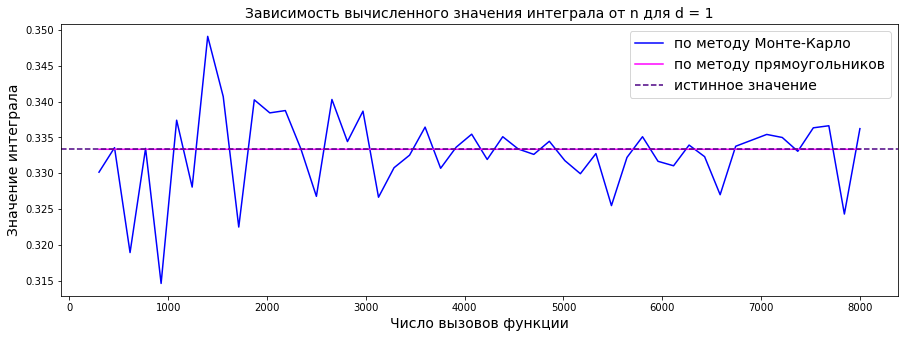

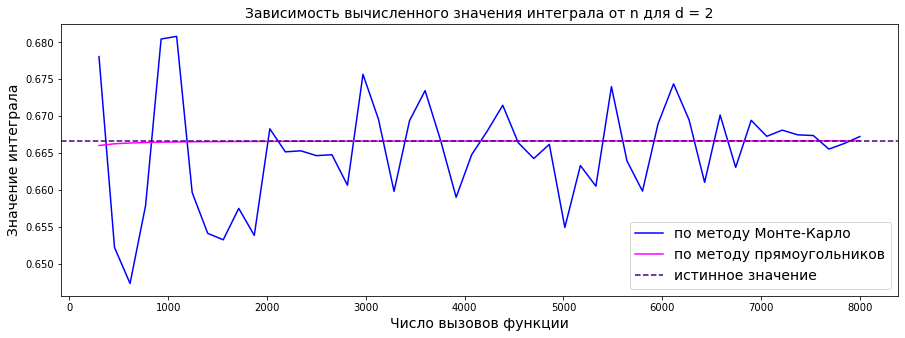

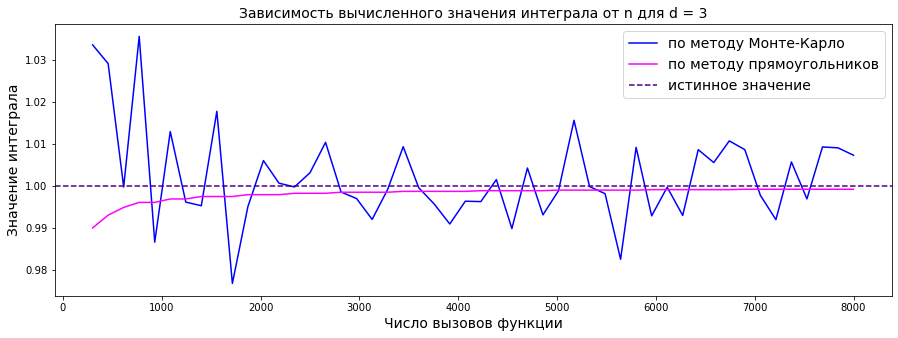

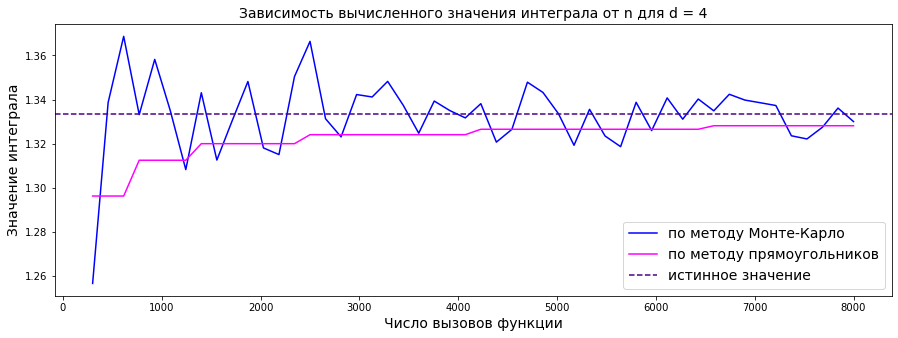

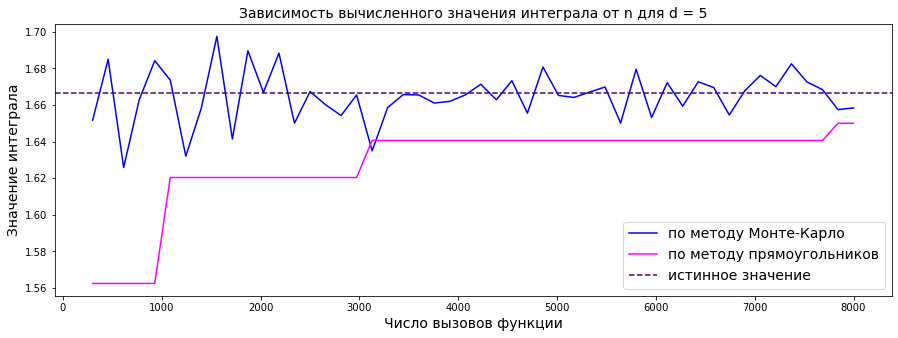

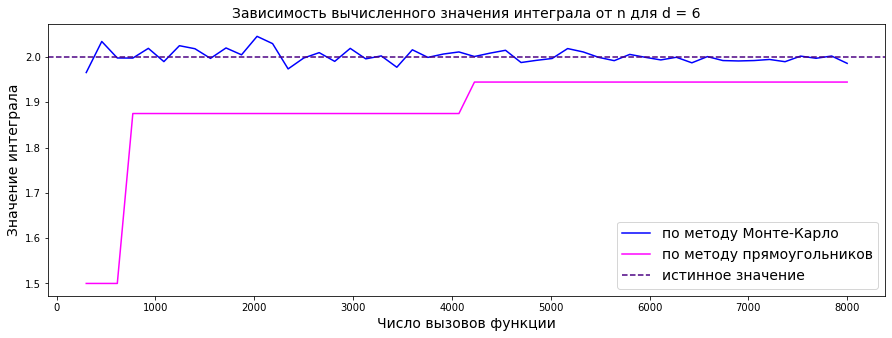

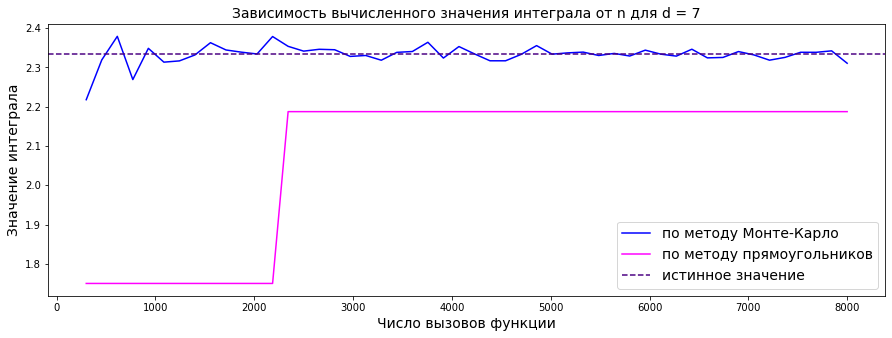

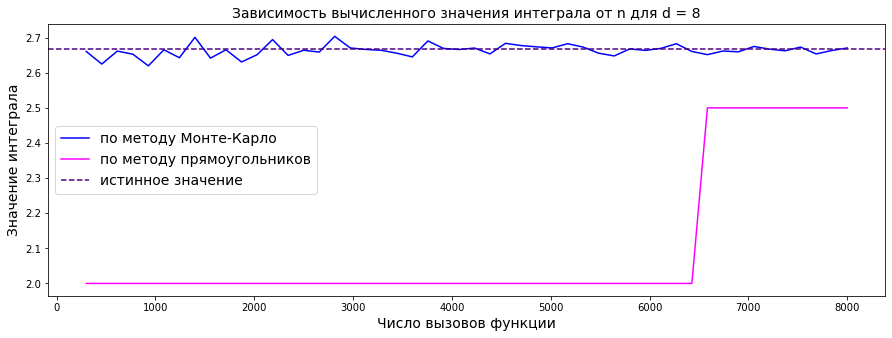

In [13]:
low = [0.0] * max_dim
high = [1.0] * max_dim
theoretical_value = np.cumsum([1/3] * 8)
n_list = np.linspace(300, max_dim * 1000, 50)

plot_convergence(square_sum, low, high, n_list, theoretical_value, max_dim)

Какой метод и при каких $d$ сходится быстрее? Предположите, в каком случае выгоднее использовать тот или иной метод.

С чем связано такое поведение графиков?

Сравните результаты с предыдущей задачей.

**Вывод:** 1) По графикам видно, что до $d = 4$ включительно быстрее сходится метод прямоугольников, $d = 5 - $ переломный момент, а вот с $d = 6$ сильно быстрее сходится метод Монте-Карло. Отсюда логично предположить, что метод прямоугольников лучше использовать для размерностей $d \le 4$, а метод Монте-Карло $ - d \ge 6$.

2) Так как в методе прямоугольников извлекается корень $d$-й степени, то $n$ должно пройти очень большой диапазон, прежде чем точность увеличится, что сильно замедляет сходимость. Более того, так как генерация выборки независимая и равномерная, а интеграл обладает симметрией по осям, при бОльших размерностях сдвиги по значениям на разных осях лучше компенсируют друг друга.

3) Так как в предыдущей задаче случай двумерный, метод прямоугольников сходился быстрее, поэтому при одинаковых $n$ он давал лучшую точность.

---
## Задача 3.

Вам предлагается численно посчитать многомерный интеграл Пуассона для размерности $d=5$ и некоторой симметричной положительно определенной матрицы $A$, которую вы выберете сами. Зависит ли интеграл от выбора $A$? 
$$\int\limits_{\mathbb{R}^d} exp( - x^T A x) dx $$

Сравните результаты двух методов с истинным значением интеграла. Как вы думаете, какой метод выдает более точный результат? Количество итераций каждого метода должно быть не менее $10^6$. Теоретическое вычисление интеграла можно не приводить, достаточно написать ответ.

**Комментарий:** В этой задаче особенно важно выбрать правильные пределы интегрирования. 
Например, для единичной матрицы достаточно взять интеграл с пределами внутри области $[-5, 5]^5$

В связи с этим просим Вас ответить на наводящие вопросы. 
1. Что будет, если выбрать слишком большие пределы в методе Монте-Карло? 
2. Что может произойти, если выбрать слишком большие пределы в методе прямоугольников?

В этой задаче нельзя использовать циклы. Для вычисления функции в точках используете простые векторно-матричные операции в `numpy`.

In [16]:
def poisson_exp(dots, A):
    """
    Векторная функция d-мерной переменной f(x) = exp(-x^{T}Ax).
    
    Аргументы:
        dots --- матрица размера (n, dim),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
        A --- положительно определённая, симметричная матрица.
            
    Возвращаемое значение:
        Вектор размерности n посчитанных значений в заданных точках.
    """
    
    dots = np.array(dots)
    return np.exp(-np.sum(dots @ A * dots, axis=1))

In [17]:
d = 5
# M = np.random.rand(d, d)
# A = M @ M.T # Получаем всегда симметричную, положительно определённую матрицу
A = np.eye(d)
print(A)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [18]:
n = 1e6

low = [-5] * d
high = [5] * d
f = lambda x: poisson_exp(x, A)

print("Theoretical value: {0:.7f}".format(
    np.pi ** (d / 2) / np.linalg.det(A)
))
print("By rectangle: {0:.7f}".format(
    Integrator.integrate(f, low, high, n)
))
print("By Monte-Karlo: {0:.7f}".format(
    Integrator.integrate(f, low, high, n, method='monte_carlo')
))

Theoretical value: 17.4934183
By rectangle: 17.4934176
By Monte-Karlo: 18.1198244


**Вывод:**
1) Теоретическая формула для значения интеграла есть $\frac{\pi^{d/2}}{\sqrt{\det{A}}}$. Поэтому, конечно, интеграл зависит от выбора А.

2) Так как размерность $d = 5$, то я думал, что метод Монте-Карло даст более точный результат. Но, как видно выше, куда точнее посчитал метод прямоугольников.

3) Если выбрать слишком большие пределы в методе Монте-Карло, то для сгенерированных точек будет больший простор для реализации конкретного значения, поэтому при неизменном $n$ и увеличивающемся интервале вклад каждого значения будет всё ощутимее, так что точность значений будет падать. Если же выбрать слишком большие пределы в методе прямоугольников, то также точность будет падать, ибо значение в центре прямогугольника будет ответственным за всё бОльшие прямоугольники.

Более того, так как будет попадать всё больше значений из областей, где функция очень мала, и всё меньше из областей, где функция велика, значение интеграла должно уменьшаться.

Рассмотрим отношение интегралов: 
$$
F(t) = \frac{ \int\limits_{-\infty}^{t_1} ... \int\limits_{-\infty}^{t_k} exp \left( - \frac12 x^T A x \right) dx}{ \int\limits_{\mathbb{R}^n} exp \left( - \frac12 x^T A x \right) dx}.
$$
В чем его вероятностный смысл?

**Вывод:** это суть функция распределения центрированного многомерного нормального распределения с матрицей ковариаций $\Sigma^{-1} = A$.

---
## Задача 4.

В заключение вам предлагается реальная практическая задача.

На основе http://ecsocman.hse.ru/data/819/759/1219/Monte_Karlo_dlya_analitikov.pdf
 	
Рассмотрим проект по разработке нефтяного месторождения. В основе модели проекта лежат предварительные данные о величине резервов месторождения.

*Замечание.* Знания физики или экономики не требуются.



*Формулировка задачи от заказчика:*
Общая задача анализа --- основываясь на величине запасов и проценте нефтеотдачи рассчитать NPV (чистая приведенная стоимость) проекта, а точнее, $0.1$-квантиль ее распределения.
Следующим этапом мы хотим использовать ее в качестве критерия оптимизации, то есть максимизировать такое значение NPV, которого мы можем достигнуть или превысить с $90\%$-й вероятностью, подобрав при этом оптимальное количество скважин на месторождении.



Предположим, что на месторождении есть $n$ скважин. Эти скважины добывают некоторую смесь, которая состоит из воды, нефти и различных примесей. Доля нефти из добытого материала называется <a href="https://ru.wikipedia.org/wiki/Нефтеотдача">коэффициентом нефтеотдачи</a> $k$. Мы будем считать, что этот коэффициент является одинаковым для всего месторождения и имеет нормальное распределение со средним $42\%$ и стандартным отклонением $1.2\%$.




**Добыча нефти скважиной за год**

<a href="http://vseonefti.ru/upstream/stadii-razrabotki.html">Разработка месторождения</a> включает три этапа:
1. фаза роста добычи --- период введения в работу новых скважин;
2. фаза плато: после достижения определенного уровня добычи, она некоторое время продолжается на постоянном уровне;
3. фаза снижения добычи --- период, когда темпы добычи экспоненциально снижаются с течением времени.


Для упрощения задачи мы пропустим два первых этапа и рассмотрим только последний.


Каждая скважина $j$ характеризуется параметром $q_j$ --- темп добычи из скважины, определяемый объемом вещества (смесь нефти, воды и др.), добываемого скважиной за сутки. Будем считать, что этот параметр является одинаковым для скважины в течении всего периода разработки и имеет нормальное распределение со средним $10$ тыс. баррелей и стандартным отклонением $3$ тыс. баррелей. Темпы добычи для разных скважин считаются независимыми случайными величинами.

Соответственно, за год $t$ скважина добывает $Q_{tj} = 365 \cdot k \cdot q_j \cdot e^{-0.008 \cdot n \cdot (t-1)}$ тыс. баррелей нефти, где экспонента отвечает за снижение добычи с течением времени.
Всего за год $t$ на месторождении добывается $Q_t = \sum\limits_{j=1}^{n} Q_{tj}$ тыс. баррелей нефти.




**Прибыль**

Стоимость барреля нефти будем считать постоянной и равной $c = 70$ долларов за баррель. Однако, для расчета стоимости нужно учесть <a href="https://ru.wikipedia.org/wiki/Ставка_дисконтирования">ставку дисконтирования</a> --- процентная ставка, используемая для пересчета будущих потоков доходов в единую величину текущей стоимости (см. формулу далее). Обозначим ее $i$ и будем считать, что она имеет нормальное распределение со средним $10\%$ и стандартным отклонением $1.2\%$.

Стоимость добытой нефти за год $t$ составит (тыс. баррелей)
$$\frac{c \cdot Q_t}{(1+i)^{t-1}}.$$

Будем считать, что разработка месторождения прекращается, если за год на всем месторождении было добыто менее $100$ тыс. баррелей нефти. Последний год разработки обозначим $T$.




**Затраты**

Затраты на месторождение (кроме скважин) составляют $C_{\text{мест.}} = 200$ млн. долларов в год. Будем считать, что издержки на содержание скважины $j$ за весь период разработки имеют треугольное распределение (<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.triang.html">scipy.stats.triang</a>) c минимальным значением $90$ млн. долларов, максимальным значением $120$ млн. долларов и модой (наиболее вероятное значение) $100$ млн. долларов. Обозначим эти случайные величины $C^j_{\text{скв.}}$ и будем считать их независимыми.




**NPV**

Теперь мы можем написать формулу NPV
$$NPV = \sum\limits_{t=1}^T \frac{c \cdot Q_t}{(1+i)^{t-1}} - T \cdot C_{\text{мест.}} - \sum\limits_{j=1}^{n} C^j_{\text{скв.}}.$$




**Задание**

С помощью метода Монте-Карло требуется найти число $x$, при котором $$\mathsf{P}(NPV < x) = 0.1.$$

Количество итераций метода должно быть не менее $100\ 000$. На основе проделанных итераций оцените также среднее значение NPV и вероятность, с которой NPV будет положительна. Кроме того, постройте нормированную гистограмму значений NPV с помощью `plt.hist(values, bins=200, normed=True)`.



Перечислим еще раз все *случайные величины*:
* Коэффициент нефтеотдачи $k$ имеет нормальное распределение со средним $42\%$ и стандартным отклонением $1.2\%$;
* $q_1, ..., q_{n}$ --- темпы добычи из скважин --- независимые нормальные случайные величины со средним $10$ тыс. баррелей и стандартным отклонением $3$ тыс. баррелей;
* Ставка дисконтирования $i$ имеет нормальное распределение со средним $10\%$ и стандартным отклонением $1.2\%$;
* $C^1_{\text{скв.}}, ..., C^{n}_{\text{скв.}}$ --- затраты на каждую скважину --- независимые  случайные величины, имеющие треугольное распределение c минимальным значением $90$ млн. долларов, максимальным значением $120$ млн. долларов и модой (наиболее вероятное значение) $100$ млн. долларов. (используйте `sps.triang(loc=90, c=1/3, scale=30)`)

Параметры считать независимыми.

*Фиксированные параметры*:
* $n = 25$ скважин;
* $365$ дней в году;
* $c=70$ долларов за баррель --- стоимость нефти;
* $100$ тыс. баррелей --- объем добытой нефти за год, при котором разработка месторождения прекращается.
* $200$ млн. долларов в год --- затраты на месторождение.

*Замечания по решению*:
* Все случайные величины надо сгенерировать заранее, до вычисления значений $T$.
* Разрешается использовать цикл по годам.
* Запрещается использовать цикл по количеству элементов в выборке.

In [19]:
# Объёмы и затраты разделены на 10^6, чтобы не работать с большими числами
n = 25
days = 365
c = 70
critical_vol = 0.1
C_place = 200

k = sps.norm(loc=0.42, scale=0.012)
q = sps.norm(loc=0.01, scale=0.003)
i = sps.norm(loc=0.1, scale=0.012)
C_well = sps.triang(loc=90, c=1/3, scale=30)

In [20]:
iters = 1000000

k_vals = k.rvs(iters) # Генерация коэффициентов нефтеотдачи
q_vals = q.rvs(size=(iters, n)) # Генерация темпов добычи для каждой вышки
i_vals = i.rvs(iters) # Генерация ставки дисконтирования
C_well_vals = C_well.rvs(size=(iters, n)) # Генерация затрат на каждую скважину

# Подготовка массивов для подсчётов, а именно: растяжение вдоль новой оси
# одномерных массивов для того, чтобы можно было удобно применять поэлементное умножение
k_vals = np.tile(k_vals, (n, 1)).T

Q_t = np.ones(iters) * critical_vol
t = np.zeros(iters)
NPV = np.zeros(iters)

weighted_q_sum = np.sort(np.sum(q_vals * k_vals, axis=1)) # Заранее посчитаем добычу нефти со всех вышек
discount_rate = np.ones(iters) # Ставку дисконтирования будем обновлять каждый ход
i_vals = 1 + i_vals # Сразу прибавим один, чтобы не вычислять сумму каждый раз

# Так как на практике T обычно около 40-45, выгоднее заранее отсортировать
while(Q_t[-1] >= critical_vol):
    able_to_work = Q_t >= critical_vol # Занулим доходы/расходы с прекративших своё существование месторождений
    t += 1 * able_to_work
    Q_t = weighted_q_sum * days * np.exp(-0.008 * n * (t - 1))
    NPV += Q_t * able_to_work / discount_rate * c
    discount_rate *= i_vals # можно домножать все, так как закрытые всё равно занулятся
NPV -= t * C_place + np.sum(C_well_vals, axis=1)

In [21]:
from scipy.stats.mstats import mquantiles

NPV /= 1e3
print("Значение NPV, \
которое достигается или превышается с 90%-й вероятностью: {0:.3f} млрд. $"\
      .format(mquantiles(NPV, [0.1])[0]))
print("Среднее значение NVP: {0:.3f} млрд. $.\nВероятность, с которой NVP положительна:\
{1:.3f}".format(NPV.mean(), np.sum(NPV > 0) / iters))

Значение NPV, которое достигается или превышается с 90%-й вероятностью: 0.742 млрд. $
Среднее значение NVP: 1.682 млрд. $.
Вероятность, с которой NVP положительна:0.993


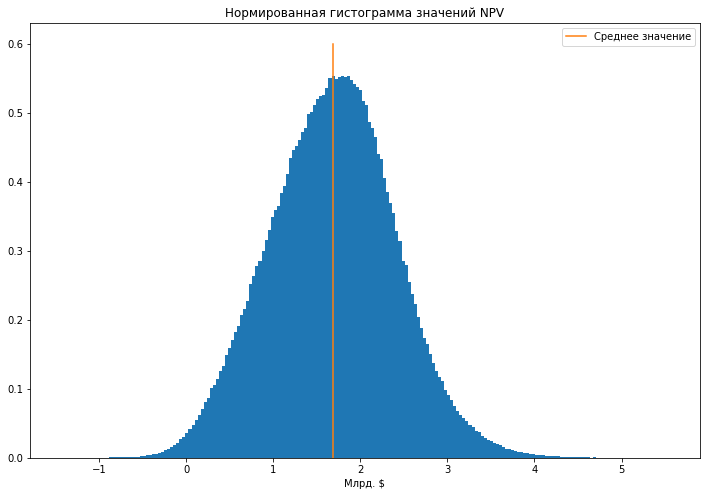

In [22]:
plt.figure(figsize=(12, 8))
plt.hist(NPV, bins=200, density=True)
plt.title('Нормированная гистограмма значений NPV')
plt.xlabel('Млрд. $')
plt.plot([NPV.mean()] * 50, np.linspace(0, 0.6), label='Среднее значение')
plt.legend(loc='best');